In [1]:
# Standard Python modules
import os, sys
%matplotlib inline

# import personal modules
sys.path.append('../')
from ar_landfall_tool_contour import landfall_tool_contour
from ar_landfall_tool_vector import landfall_tool_vector
from ar_landfall_tool_IVT_mag import landfall_tool_IVT_magnitude
from cw3e_tools import load_datasets

# pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
%%time

model = 'ECMWF'
loc = 'US-west'
ptloc = 'coast'

if model == 'ECMWF-GEFS':   
    s = load_datasets('ECMWF', loc, ptloc)
    ds_pt_ECMWF, ds_ECMWF = s.calc_ivt_vars()
    model_init_date = ds_pt_ECMWF.model_init_date
    date_string = model_init_date.strftime('%Y%m%d%H')
    path_to_data = '/data/downloaded/SCRATCH/cw3eit_scratch/'
    fname = path_to_data + 'GEFS/FullFiles/IVT_Full_{0}.nc'.format(date_string)
    
    s = load_datasets('GEFS', loc, ptloc, fname)
    ds_pt_GEFS, ds_GEFS = s.calc_ivt_vars()
    
    ## subtract ECMWF - GEFS
    ds_pt = ds_pt_ECMWF-ds_pt_GEFS
    ds = ds_ECMWF-ds_GEFS
    
else:
    s = load_datasets(model, loc, ptloc)
    ds_pt, ds = s.calc_ivt_vars()

if model == 'ECMWF' or model == 'GEFS':
    prec = s.load_prec_QPF_dataset()

Ignoring index file '../data/precip_ECMWF.923a8.idx' older than GRIB file


CPU times: user 12.6 s, sys: 5.19 s, total: 17.8 s
Wall time: 17.8 s


/home/dnash/repos/cw3e_ar-tools/analysis/../ar_landfall_tool_contour.py:181: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  self.cf = ax.pcolormesh(x, y, data, cmap=cmap, norm=norm, rasterized=True)


FileNotFoundError: [Errno 2] No such file or directory: '/cw3e_ar-tools/figs/US-west/ECMWF_LandfallTool_250.0_coast_current.png'

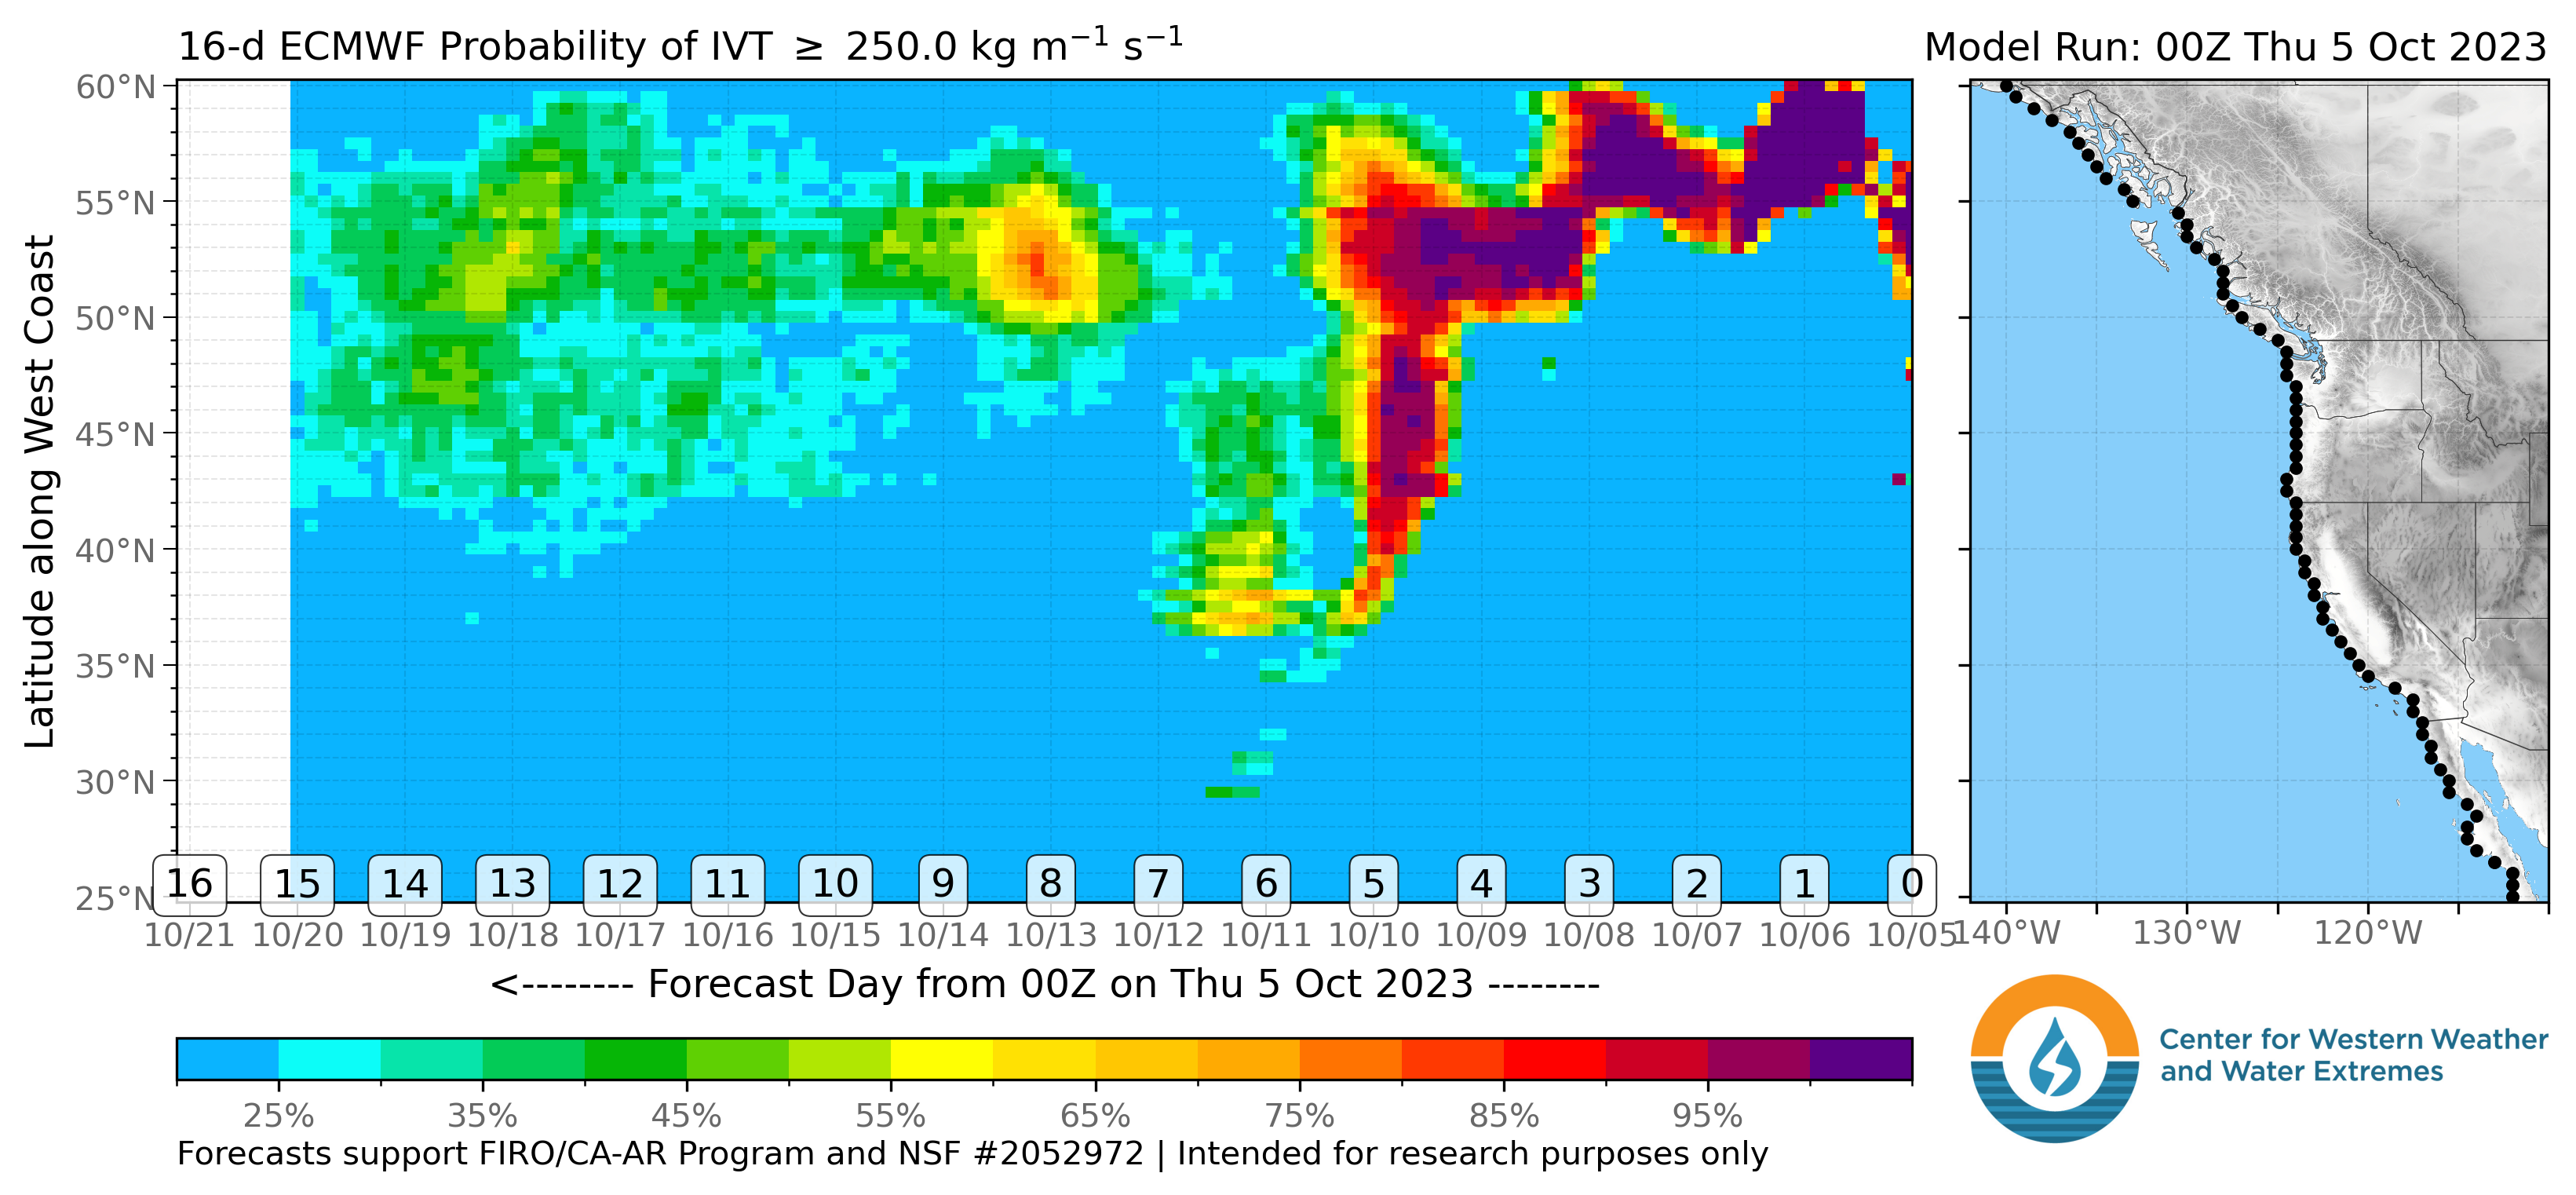

In [3]:
s = landfall_tool_contour(ds_pt=ds_pt, loc=loc, ptloc=ptloc, forecast=model, threshold=250., orientation='latitude')
s.create_figure()

In [4]:
loc = 'US-West'
ori = 'latitude'
model_lst = ['GEFS', 'ECMWF', 'W-WRF', 'ECMWF-GEFS']
ptloc_lst = ['coast', 'foothills', 'inland']
threshold_lst = [150, 250, 500, 750]

# for each model and point location, load the data, then calculate each metric
for i, (model, ptloc) in enumerate(zip(model_lst, ptloc_lst)):
    
    ################################
    ### Create Intermediate Data ###
    ################################
    ## load the data - this loads and calculates for all metrics and IVT thresholds for the given model and pt location
    s = load_datasets(model, loc, ptloc)
    ds_pt, ds = s.calc_ivt_vars()
    
    if model == 'ECMWF' or model == 'GEFS':
        prec = s.load_prec_QPF_dataset()
    
    ##########################################
    ### Create Plots for Intermediate Data ###
    ##########################################
    ## plot control magnitude plots (this doesn't need to loop through thresholds)
    s = landfall_tool_IVT_magnitude(loc=loc, ptloc=ptloc, forecast=model, mag_type='control', orientation=ori)
    s.create_figure()
    
    ## plot ensemble mean magnitude plots (this doesn't need to loop through thresholds)
    s = landfall_tool_IVT_magnitude(loc=loc, ptloc=ptloc, forecast=model, mag_type='ensemble', orientation=ori)
    s.create_figure()
    
    ## plot vector and contour landfall plots (this will loop through all the thresholds)
    for j, thres in enumerate(threshold_lst):
        s = landfall_tool_vector(loc=loc, ptloc=ptloc, forecast=model, threshold=thres, orientation=ori)
        s.create_figure()
        
        if model == 'ECMWF' or model == 'GEFS':
            s = landfall_tool_contour(loc=loc, ptloc=ptloc, forecast=model, threshold=thres, orientation=ori)
            s.create_figure()

<xarray.Dataset>
Dimensions:        (forecast_hour: 105, location: 75, ensemble: 31, threshold: 4)
Coordinates:
  * forecast_hour  (forecast_hour) float32 0.0 3.0 6.0 9.0 ... 372.0 378.0 384.0
    lat            (location) float32 60.0 59.5 59.0 58.5 ... 26.0 25.5 25.0
    lon            (location) float32 -140.0 -139.5 -138.5 ... -112.0 -112.0
  * ensemble       (ensemble) int32 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
  * threshold      (threshold) float64 150.0 250.0 500.0 750.0
Dimensions without coordinates: location
Data variables:
    ensemble_mean  (forecast_hour, location) float32 170.4 277.1 ... 75.73 81.16
    control        (forecast_hour, location) float32 171.0 278.7 ... 15.06 26.43
    v              (forecast_hour, location) float32 0.9272 0.9011 ... -0.1995
    u              (forecast_hour, location) float32 0.3644 0.4213 ... 0.6068
    duration       (threshold, ensemble, location) int64 33 126 174 ... 15 18 12

In [ ]:
%%time
# date = '20230711' # today's date
# hr = '06' # time start
# url = 'https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs{0}/gfs_0p25_{1}z'.format(date, hr)
# ds = xr.open_dataset(url, decode_times=True)
# ds = ds.isel(time=7*8) # select day 7
# prec = ds['apcpsfc'].sum('time')/25.4 # convert from mm to in
# prec

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-130., -110., 25., 55.])
# cmap, norm, bnds = cw3e.cmap('brian_qpf')
# prec.plot.contourf(ax=ax, cmap=cmap, levels=bnds, norm=norm, extend='max', transform=ccrs.PlateCarree())
# ax.coastlines()

In [ ]:
# ds = xr.open_dataset('/data/downloaded/WWRF-NRT/2023-2024/Ensemble_IVT/IVT_WWRF_2023092200.nc')
# ds

In [ ]:
ds = xr.open_dataset('../preprocess/precip.grb', engine='cfgrib')